# Интерпретируемая модель

Обучение модели логистической регрессии на WoE биннинге

- Монотонный биннинг
- Максимальное кол-во бинов - 4
- Минимальный размер бина - 5% 

Отбор факторов:
- Порог по корреляции Пирсона - 0.9
- Порог по VIF - 10
- Порог по индивидуальной ранжирующей силе фактора - 6 Джини
- Отбор по важности фактора

In [19]:
import typing
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autowoe import AutoWoE, ReportDeco
from scipy.stats import rankdata
from sklearn.metrics import accuracy_score, auc, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import KBinsDiscretizer
from tqdm.notebook import tqdm
import scipy.stats as ss

In [2]:
cat_features = [
    "emp_title",
    "home_ownership",
    "verification_status",
    "purpose",
    "zip_code",
    "addr_state",
    "initial_list_status",
    "application_type",
    "verification_status_joint",
    "disbursement_method",
]
TARGET = "target"

In [15]:
samples = dict()
for k in ["train", "oos", "oot"]:
    samples[k] = pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet")
    samples[k] = samples[k][samples[k]["target"] != -1].reset_index(drop=True)

In [4]:
features = sorted(
    set(samples["train"].columns)
    - {
        "target",
        "issue_d",
        "last_pymnt_d",
        "next_pymnt_d",
        "int_rate",
        "term",
        "installment",
        "funded_amnt",
        "funded_amnt_inv",
        "loan_amnt",
        "dti",
        "dti_joint",
        "inq_fi",  # немонотонный фактор
    }
)

In [5]:
samples["train"][features].head()

,addr_state,all_util,annual_inc,annual_inc_joint,application_type,bc_open_to_buy,debt_load,desc,disbursement_method,earliest_cr_line,...,tot_coll_amt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,verification_status,verification_status_joint,zip_code
0,TX,NaN,62000.0,NaN,Individual,5829.0,0.126908,False,Cash,6181.0,...,0.0,189075.0,25971.0,31800.0,NaN,0.0,32800.0,Verified,__NAN__,784xx
1,CA,NaN,51300.0,NaN,Individual,NaN,0.091214,True,Cash,4322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Verified,__NAN__,945xx
2,MT,NaN,75000.0,NaN,Individual,41744.0,0.078194,False,Cash,5143.0,...,0.0,83800.0,16441.0,50900.0,NaN,0.0,83800.0,Verified,__NAN__,598xx
3,NY,NaN,61845.0,NaN,Individual,12981.0,0.147572,False,Cash,3652.0,...,0.0,67500.0,43905.0,27300.0,NaN,34000.0,33500.0,Source Verified,__NAN__,113xx
4,OH,NaN,41000.0,NaN,Individual,1168.0,0.079469,False,Cash,5264.0,...,0.0,155452.0,33644.0,4500.0,NaN,31308.0,7300.0,Not Verified,__NAN__,441xx


In [6]:
auto_woe = AutoWoE(
    monotonic=True,
    max_bin_count=4,
    pearson_th=0.9,
    vif_th=10.0,
    auc_th=0.53,
    imp_th=0.001,
    th_const=32,
    force_single_split=True,
    min_bin_size=0.05,
    oof_woe=True,
    n_folds=5,
    n_jobs=16,
    regularized_refit=True,
    verbose=0,
)

auto_woe.fit(
    samples["train"][[*features, TARGET]],
    target_name=TARGET,
    validation=samples["oos"][[*features, TARGET]],
    features_type=dict(zip(features, ["cat" if f in cat_features else "real" for f in features])),
)

[LightGBM] [Warning] Starting from the 2.1.2 version, default value for the "boost_from_average" parameter in "binary" objective is true.
This may cause significantly different results comparing to the previous versions of LightGBM.
Try to set boost_from_average=false, if your old models produce bad results
[LightGBM] [Info] Number of positive: 125207, number of negative: 504883
[LightGBM] [Info] Total Bins 12183
[LightGBM] [Info] Number of data: 630090, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198713 -> initscore=-1.394358
[LightGBM] [Info] Start training from score -1.394358


In [7]:
roc_auc_score(samples["oot"][TARGET], auto_woe.predict_proba(samples["oot"][features]))

0.6603883229049875

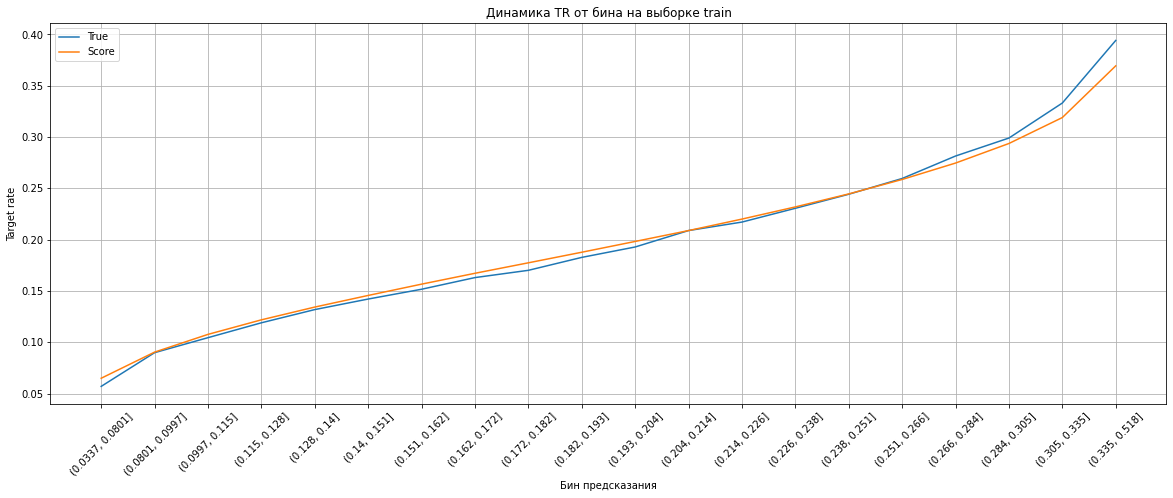

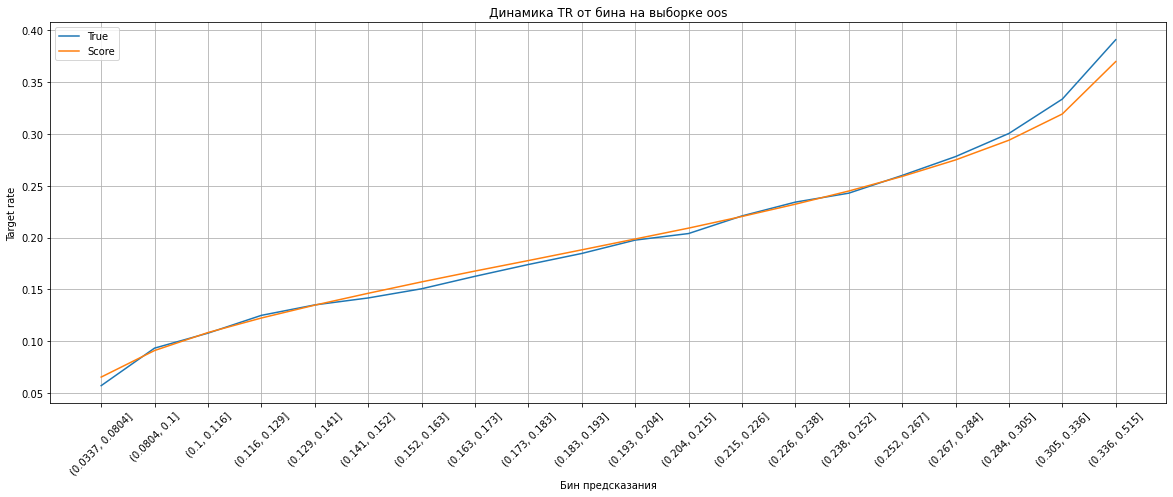

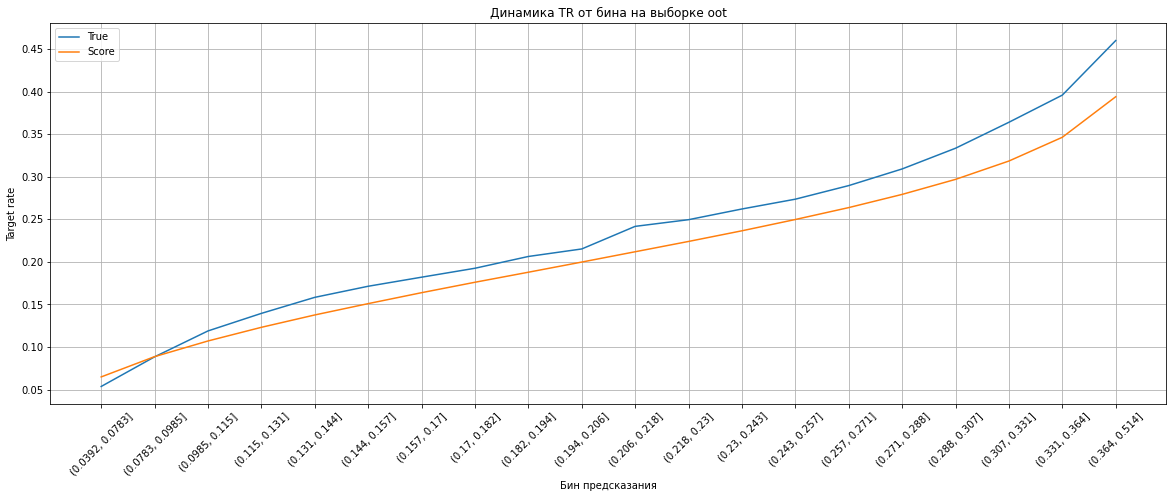

In [8]:
for k, v in samples.items():
    x = v[v["target"] != -1]
    y_true = x["target"].values
    y_score = auto_woe.predict_proba(x[features])
    data = pd.DataFrame({"true": y_true, "score": y_score})
    x = data.assign(q=pd.qcut(data["score"], q=20, duplicates="drop")).groupby("q").agg("mean")
    xi = np.arange(len(x))
    plt.figure(figsize=(20, 7), facecolor="w")
    plt.plot(xi, x["true"].values, label="True")
    plt.plot(xi, x["score"].values, label="Score")
    plt.xticks(xi, x.index, rotation=45)

    plt.xlabel("Бин предсказания")
    plt.ylabel("Target rate")
    plt.title(f"Динамика TR от бина на выборке {k}")
    plt.grid()
    plt.legend()
    plt.show()

In [21]:
calibration_res =[]
for k, v in samples.items():
    s = v[v["target"] != -1]
    y_true = s['target'].values
    y_score = auto_woe.predict_proba(s[features])
    
    lb, ub = [x / len(s) for x in ss.binom.interval(n=len(s), p=y_score.mean(), alpha=0.95)]
    calibration_res.append({
        'sample': k,
        'TR': y_true.mean(),
        'SR': y_score.mean(),
        'LB': lb,
        'UB': ub,
        'OK': lb <=  y_true.mean() <= ub,
    })
calibration_res = pd.DataFrame(calibration_res)
calibration_res

,sample,TR,SR,LB,UB,OK
0,train,0.198634,0.198635,0.197754,0.199517,True
1,oos,0.199663,0.199009,0.197662,0.200356,True
2,oot,0.235284,0.211065,0.209406,0.212726,False


In [9]:
for k in ["train", "oos", "oot"]:
    sample = pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}.parquet")
    sample["score"] = auto_woe.predict_proba(sample[features])
    sample.to_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_{k}_with_score_WoE.parquet")

In [10]:
auto_woe.feature_history

{'addr_state': 'Pruned during regression refit',
 'all_util': None,
 'annual_inc': None,
 'annual_inc_joint': 'Low importance',
 'application_type': 'Low importance',
 'bc_open_to_buy': None,
 'debt_load': None,
 'desc': 'Pruned during regression refit',
 'disbursement_method': 'Low importance',
 'earliest_cr_line': 'Pruned during regression refit',
 'emp_length': 'Pruned during regression refit',
 'emp_title': 'Pruned during regression refit',
 'fico_range_high': None,
 'fico_range_low': 'Low importance',
 'fraq_annual_inc': 'Low importance',
 'home_ownership': None,
 'initial_list_status': 'Low importance',
 'log_annual_inc': 'Low importance',
 'mort_acc': None,
 'num_bc_sats': 'Pruned during regression refit',
 'num_bc_tl': 'Low importance',
 'num_il_tl': 'Low importance',
 'num_op_rev_tl': 'Pruned during regression refit',
 'num_rev_accts': 'Pruned during regression refit',
 'num_rev_tl_bal_gt_0': None,
 'num_sats': 'Pruned during regression refit',
 'open_acc': 'Pruned during regr

In [11]:
auto_woe.get_model_represenation()

{'features': {'fico_range_high': {'f_type': 'real',
   'splits': [686.5, 706.5, 741.5],
   'cod_dict': {0: -0.279756, 1: -0.013817, 2: 0.330981, 3: 0.897789},
   'weight': -0.6955448651854876,
   'nan_value': '__NaN_0__',
   'spec_cod': {'__NaN_0__': 0.0}},
  'debt_load': {'f_type': 'real',
   'splits': [0.047605, 0.078956, 0.100544],
   'cod_dict': {0: 0.423368, 1: 0.114124, 2: -0.110741, 3: -0.34456},
   'weight': -0.8057582271463819,
   'nan_value': '__NaN_0__',
   'spec_cod': {'__NaN_0__': 0.0}},
  'bc_open_to_buy': {'f_type': 'real',
   'splits': [2729.5, 9394.5, 28283.5],
   'cod_dict': {0: -0.200611, 1: -0.045331, 2: 0.214201, 3: 0.624867},
   'weight': -0.07595649379553651,
   'nan_value': '__NaN__',
   'spec_cod': {'__NaN__': 0.241646}},
  'verification_status': {'f_type': 'cat',
   'cat_map': {'Not Verified': 0, 'Source Verified': 1, 'Verified': 2},
   'spec_cat': ({'Not Verified', 'Source Verified', 'Verified'},
    '__Small_0__'),
   'cod_dict': {0: 0.376606, 1: -0.073896, 

In [12]:
results = []
for k, v in auto_woe.get_model_represenation()["features"].items():
    if v["f_type"] == "real":
        for i, thr in enumerate(v["splits"]):
            thr = np.round(thr, 3)
            row = {"feature": k, "weight": v["weight"], "condition": 0, "WoE": v["cod_dict"][i]}
            if i == 0:
                row["condition"] = "X <= {}".format(thr)
            else:
                row["condition"] = "{} < X <= {}".format(np.round(v["splits"][i - 1], 3), thr)
            results.append(row)
        results.append(
            {
                "feature": k,
                "weight": v["weight"],
                "condition": "X > {}".format(np.round(v["splits"][-1], 3)),
                "WoE": v["cod_dict"][i + 1],
            }
        )
        if v["spec_cod"][v["nan_value"]]:
            results.append(
                {
                    "feature": k,
                    "weight": v["weight"],
                    "condition": "NaN",
                    "WoE": v["spec_cod"][v["nan_value"]],
                }
            )
    elif v["f_type"] == "cat":
        s = pd.Series(v["cat_map"]).reset_index().groupby(0)["index"].agg(list)
        for code, names in s.items():
            row = {
                "feature": k,
                "weight": v["weight"],
                "condition": "X in {}".format(names),
                "WoE": v["cod_dict"][code],
            }
            results.append(row)
results.append(
    {"feature": "intercept", "weight": auto_woe.get_model_represenation()["intercept"], "condition": "", "WoE": None}
)
results = pd.DataFrame(results)
results.set_index(
    [
        "feature",
        "weight",
        "condition",
    ]
).style

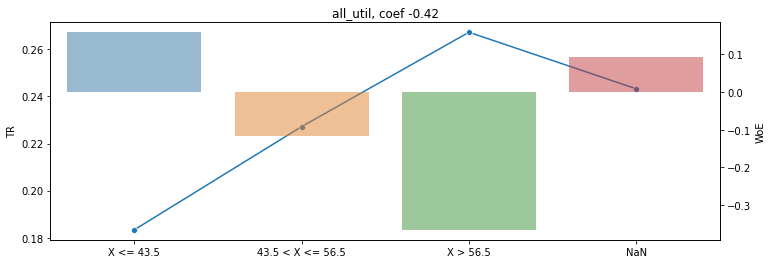

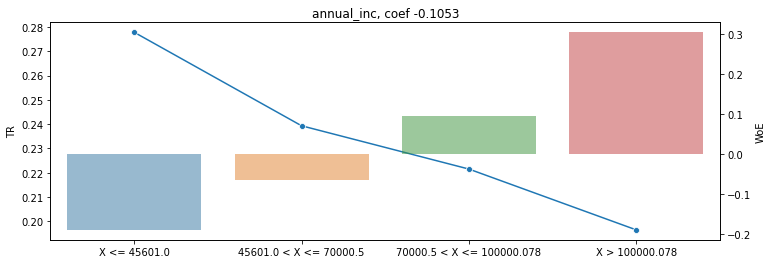

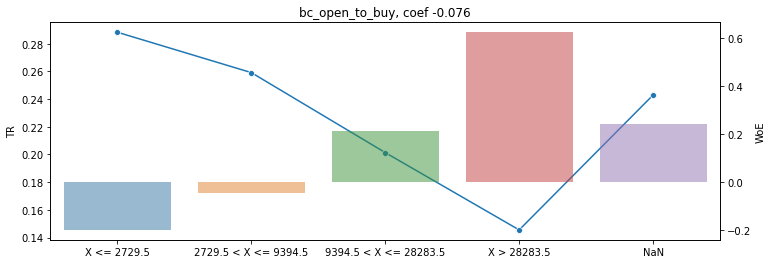

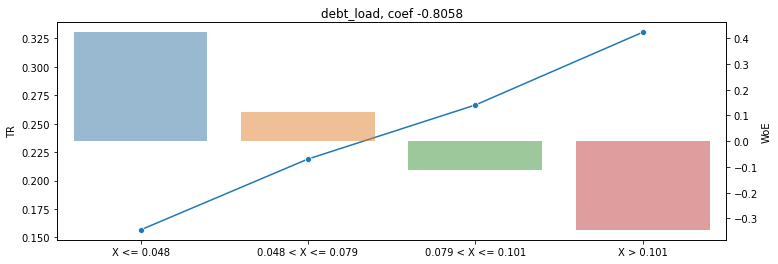

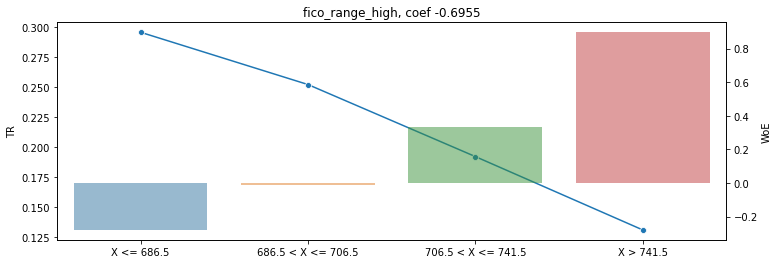

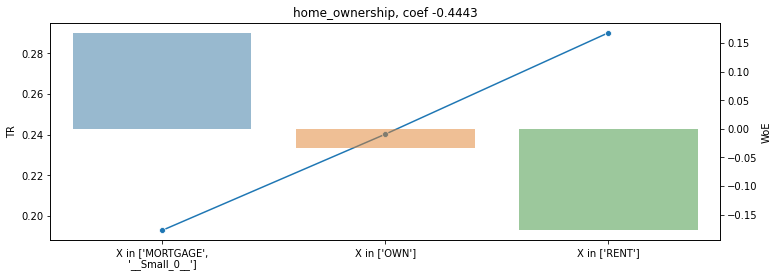

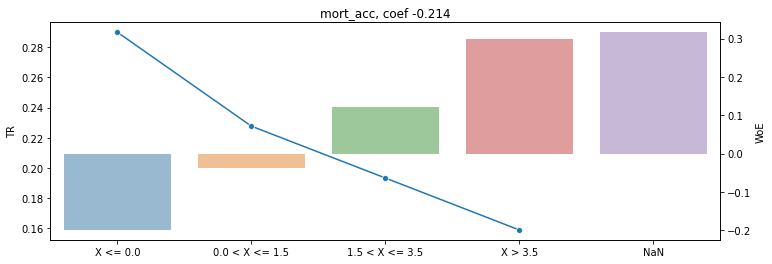

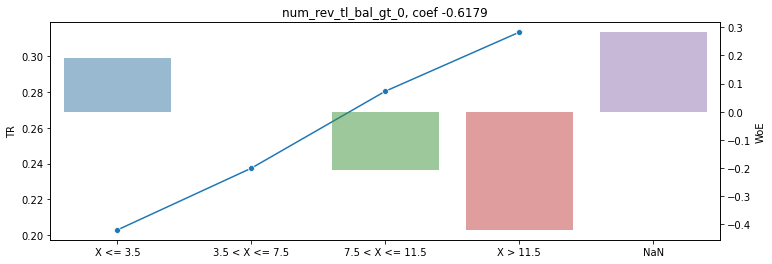

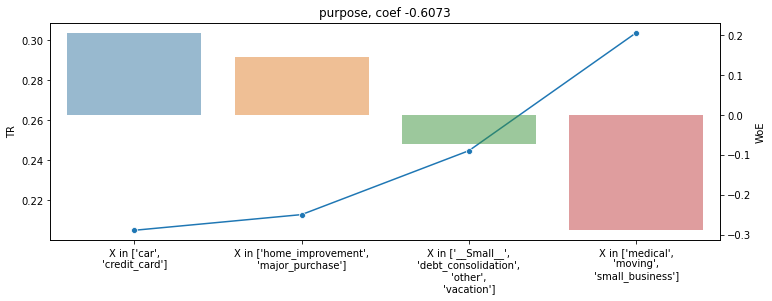

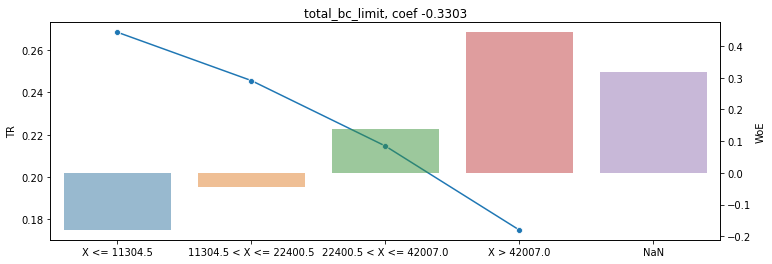

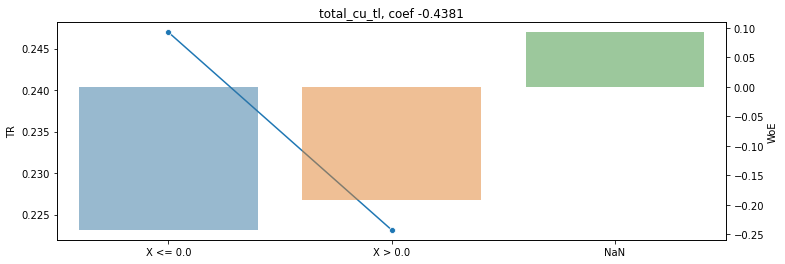

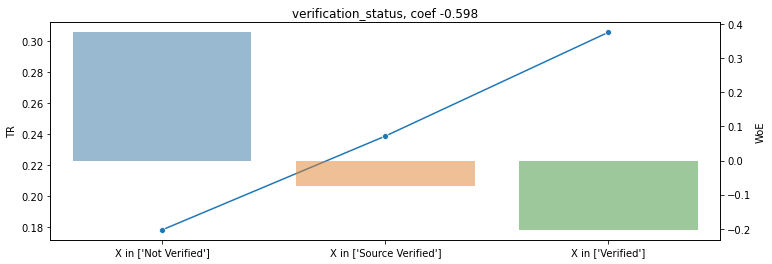

In [13]:
s = auto_woe.test_encoding(samples["oot"])
s["target"] = samples["oot"]["target"]
for f, res in results.assign(condition=results["condition"].map(lambda x: x.replace(", ", ",\n"))).groupby("feature"):
    if f != "intercept":
        fig, ax1 = plt.subplots(figsize=(12, 4))
        d = s.round(6).groupby(f)["target"].mean().to_dict()

        sns.lineplot(
            data=pd.Series([d.get(w, None) for w in res["WoE"].values], name="TR"), marker="o", sort=False, ax=ax1
        )
        ax2 = ax1.twinx()

        sns.barplot(x=res["condition"], y=res["WoE"], order=res["condition"], alpha=0.5, ax=ax2)
        plt.title(f + ", coef " + str(np.round(res["weight"].values[0], 4)))
        plt.show()